<a href="https://colab.research.google.com/github/shoreey/Glycemic-Event-Forecasting-Using-Continuous-Glucose-Monitoring-Data/blob/main/Glycemic_Event_Forecasting_Using_Continuous_Glucose_Monitoring_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Library

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Importing the Dataset

In [ ]:
# Path to the folder containing all Excel files
folder_path = r"E:\Machine_Learning\Data"

# List to store DataFrames for each file
dfs = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xlsx") and not file_name.startswith("~$"):
        file_path = os.path.join(folder_path, file_name)

        # Read Excel file into a DataFrame
        df = pd.read_excel(file_path)

        # Convert 'Time' column to datetime format
        df['Time'] = pd.to_datetime(df['Time'])

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df.head())


                 Time          BG         CGM  CHO   insulin  LBGI      HBGI  \
0 2023-10-25 06:00:00  126.013943  136.435033  0.0  0.013933   0.0  0.446600   
1 2023-10-25 06:05:00  126.589661  137.121412  0.0  0.013933   0.0  0.483302   
2 2023-10-25 06:10:00  127.155902  138.398018  0.0  0.013933   0.0  0.520644   
3 2023-10-25 06:15:00  127.712577  140.060899  0.0  0.013933   0.0  0.558542   
4 2023-10-25 06:20:00  128.259611  141.830932  0.0  0.013933   0.0  0.596914   

       Risk  
0  0.446600  
1  0.483302  
2  0.520644  
3  0.558542  
4  0.596914  


# Data Preprocessing

In [ ]:
# Check for missing values
print(combined_df.isnull().sum())

# Handle missing values if needed (e.g., using fillna or dropping rows/columns)

# Check data types
print(combined_df.dtypes)

# If needed, convert data types (e.g., ensure numeric columns are of numeric types)


Time       0
BG         0
CGM        0
CHO        0
insulin    0
LBGI       0
HBGI       0
Risk       0
dtype: int64
Time       datetime64[ns]
BG                float64
CGM               float64
CHO               float64
insulin           float64
LBGI              float64
HBGI              float64
Risk              float64
dtype: object


# Feature Engineering

In [ ]:
# Assuming 'Time' is sorted, calculate average values over the past 24 hours for each feature
combined_df['CGM_avg_24hrs'] = combined_df['CGM'].rolling(window=288, min_periods=1).mean()
combined_df['CHO_avg_24hrs'] = combined_df['CHO'].rolling(window=288, min_periods=1).mean()
combined_df['insulin_avg_24hrs'] = combined_df['insulin'].rolling(window=288, min_periods=1).mean()

# Create 'CHO_future' and 'insulin_future' columns
combined_df['CHO_future'] = combined_df['CHO'].shift(-1)
combined_df['insulin_future'] = combined_df['insulin'].shift(-1)

# Target Variable

In [ ]:
# Create a binary column indicating hypoglycemia (1) or hyperglycemia (2) in the next 2 hours
combined_df['target'] = 0  # Default value for no event
combined_df.loc[combined_df['CGM'].shift(-24) < 70, 'target'] = 1  # Hypoglycemia
combined_df.loc[combined_df['CGM'].shift(-24) > 180, 'target'] = 2  # Hyperglycemia

# Time Split

C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\3857092492.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  split_time = pd.to_datetime('27/10/2023 12:00')


Training Set Shape: (14256, 15)
Testing Set Shape: (17424, 15)
Training Set:
                 Time          BG         CGM  CHO   insulin  LBGI      HBGI  \
0 2023-10-25 06:00:00  126.013943  136.435033  0.0  0.013933   0.0  0.446600   
1 2023-10-25 06:05:00  126.589661  137.121412  0.0  0.013933   0.0  0.483302   
2 2023-10-25 06:10:00  127.155902  138.398018  0.0  0.013933   0.0  0.520644   
3 2023-10-25 06:15:00  127.712577  140.060899  0.0  0.013933   0.0  0.558542   
4 2023-10-25 06:20:00  128.259611  141.830932  0.0  0.013933   0.0  0.596914   

       Risk  CGM_avg_24hrs  CHO_avg_24hrs  insulin_avg_24hrs  CHO_future  \
0  0.446600     136.435033            0.0           0.013933         0.0   
1  0.483302     136.778222            0.0           0.013933         0.0   
2  0.520644     137.318154            0.0           0.013933         0.0   
3  0.558542     138.003841            0.0           0.013933         0.0   
4  0.596914     138.769259            0.0           0.013933  

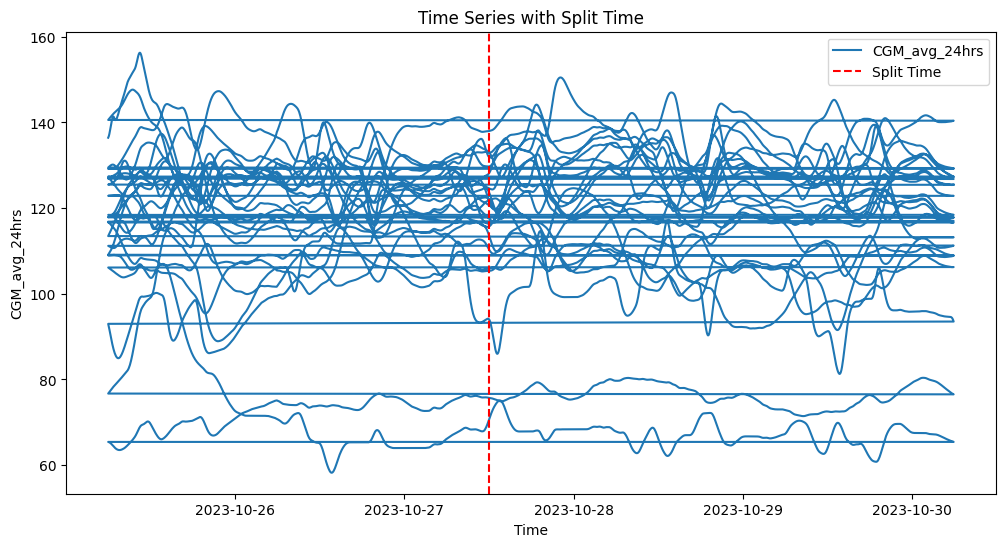

In [ ]:
# Choose your desired split time
split_time = pd.to_datetime('27/10/2023 12:00')

# Split the data into training and testing sets
train_df = combined_df[combined_df['Time'] < split_time]
test_df = combined_df[combined_df['Time'] >= split_time]

# Check the shapes of the training and testing sets
print("Training Set Shape:", train_df.shape)
print("Testing Set Shape:", test_df.shape)
# Display the first few rows of the training and testing sets
print("Training Set:")
print(train_df.head())

print("\nTesting Set:")
print(test_df.head())


# Plot the time series with highlighted split time
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Time'], combined_df['CGM_avg_24hrs'], label='CGM_avg_24hrs')
plt.axvline(x=split_time, color='red', linestyle='--', label='Split Time')
plt.title('Time Series with Split Time')
plt.xlabel('Time')
plt.ylabel('CGM_avg_24hrs')
plt.legend()
plt.show()


# Model Development

# To check the pipeline including Future Data of CHO and Insulin

# Selecting Features and Target Variable

In [ ]:
# Select features and target variable
features = ['CGM_avg_24hrs', 'CHO_avg_24hrs', 'insulin_avg_24hrs', 'CHO_future', 'insulin_future']
target = 'target'

# Assuming 'Time' is sorted, create a new column for the time of the next carbohydrates intake
combined_df['CHO_future_time'] = combined_df['Time'].shift(-1)

# Filter 'CHO_future' based on the requirement
test_df['CHO_future'] = test_df.apply(lambda row: row['CHO_future'] if row['Time'] + pd.Timedelta(hours=2) >= row['CHO_future_time'] else None, axis=1)

# Impute missing values in the target variable with the most frequent class
most_frequent_class = train_df[target].mode()[0]
train_df[target].fillna(most_frequent_class, inplace=True)
test_df[target].fillna(most_frequent_class, inplace=True)

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(train_df[features])
X_test_imputed = imputer.transform(test_df[features])


C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\283520463.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['CHO_future'] = test_df.apply(lambda row: row['CHO_future'] if row['Time'] + pd.Timedelta(hours=2) >= row['CHO_future_time'] else None, axis=1)
C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\283520463.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target].fillna(most_frequent_class, inplace=True)
C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\283520463.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

# Model Initialization

In [ ]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_imputed, train_df[target])

# Predict on the test set
y_pred = rf_classifier.predict(X_test_imputed)

# Model Evaluation

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(test_df[target], y_pred))

# Calculate confusion matrix
cm = confusion_matrix(test_df[target], y_pred)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77     12266
           1       0.55      0.25      0.34      3240
           2       0.22      0.29      0.25      1918

    accuracy                           0.65     17424
   macro avg       0.50      0.45      0.46     17424
weighted avg       0.65      0.65      0.64     17424

[[9957  587 1722]
 [2205  813  222]
 [1290   77  551]]


# Visualization

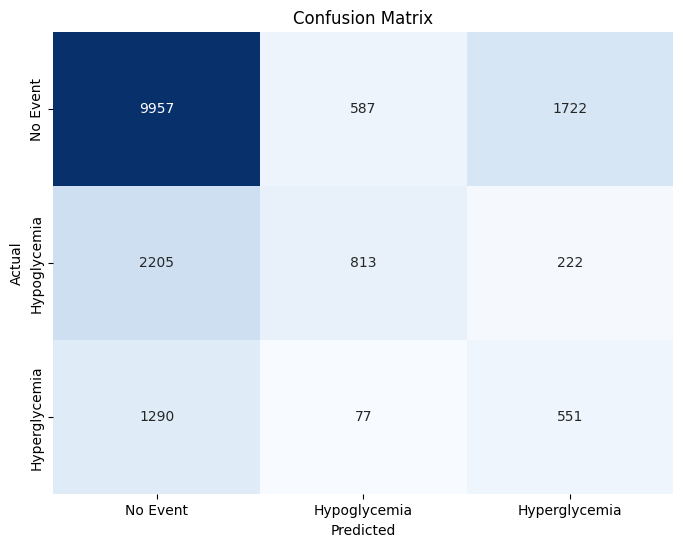

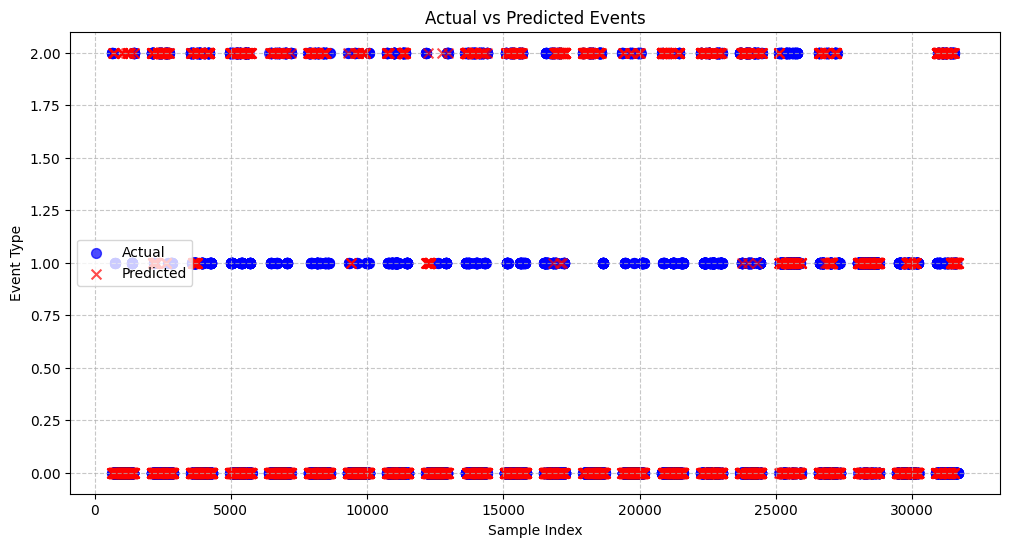

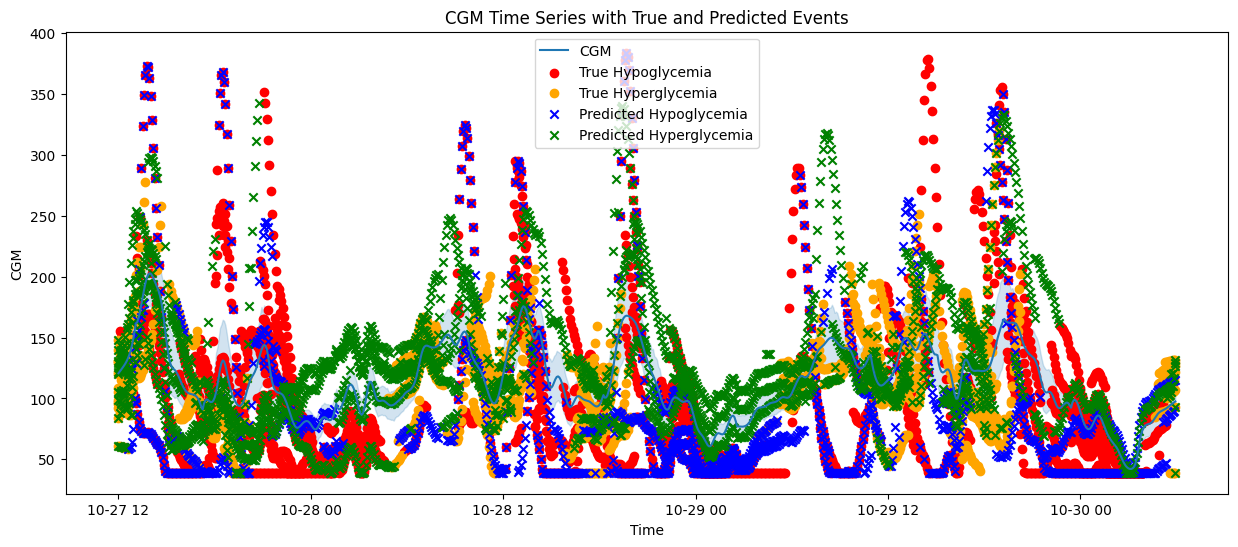

In [ ]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot actual vs predicted events with different markers and colors
plt.figure(figsize=(12, 6))
plt.scatter(test_df.index, test_df[target].values, label='Actual', color='blue', marker='o', alpha=0.7, s=50)
plt.scatter(test_df.index, y_pred, label='Predicted', color='red', marker='x', alpha=0.7, s=50)
plt.title('Actual vs Predicted Events')
plt.xlabel('Sample Index')
plt.ylabel('Event Type')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns


# Plotting the time series with true events and predictions
plt.figure(figsize=(15, 6))

# Plot CGM values
sns.lineplot(x='Time', y='CGM', data=test_df, label='CGM')

# Highlight true events
true_hypo = test_df[test_df['target'] == 1]
true_hyper = test_df[test_df['target'] == 2]
plt.scatter(true_hypo['Time'], true_hypo['CGM'], color='red', marker='o', label='True Hypoglycemia')
plt.scatter(true_hyper['Time'], true_hyper['CGM'], color='orange', marker='o', label='True Hyperglycemia')

# Highlight predicted events
predicted_hypo = test_df[y_pred == 1]
predicted_hyper = test_df[y_pred == 2]
plt.scatter(predicted_hypo['Time'], predicted_hypo['CGM'], color='blue', marker='x', label='Predicted Hypoglycemia')
plt.scatter(predicted_hyper['Time'], predicted_hyper['CGM'], color='green', marker='x', label='Predicted Hyperglycemia')

plt.title('CGM Time Series with True and Predicted Events')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.legend()
plt.show()



# Tuned Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_imputed, train_df[target])

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_tuned = best_rf_model.predict(X_test_imputed)

# Print classification report for the tuned model
print("Classification Report (Tuned Model):")
print(classification_report(test_df[target], y_pred_tuned))

# Calculate confusion matrix for the tuned model
cm_tuned = confusion_matrix(test_df[target], y_pred_tuned)

print(cm_tuned)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.74      0.90      0.81     12266
           1       0.60      0.23      0.33      3240
           2       0.31      0.19      0.24      1918

    accuracy                           0.70     17424
   macro avg       0.55      0.44      0.46     17424
weighted avg       0.66      0.70      0.66     17424

[[11024   423   819]
 [ 2476   746    18]
 [ 1477    68   373]]


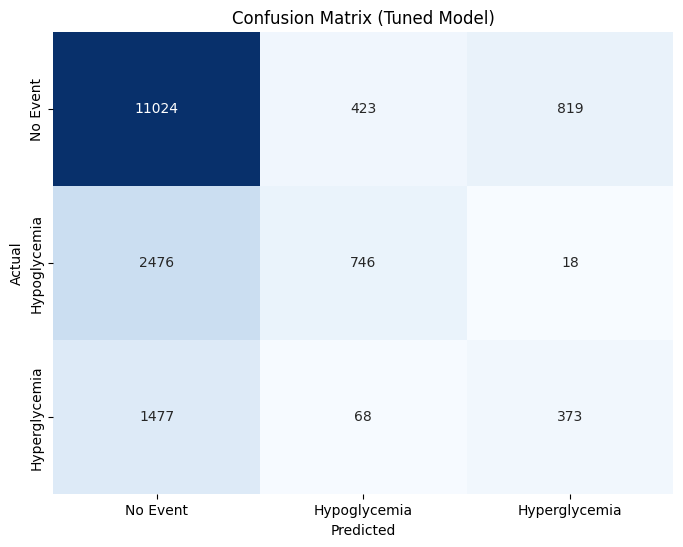

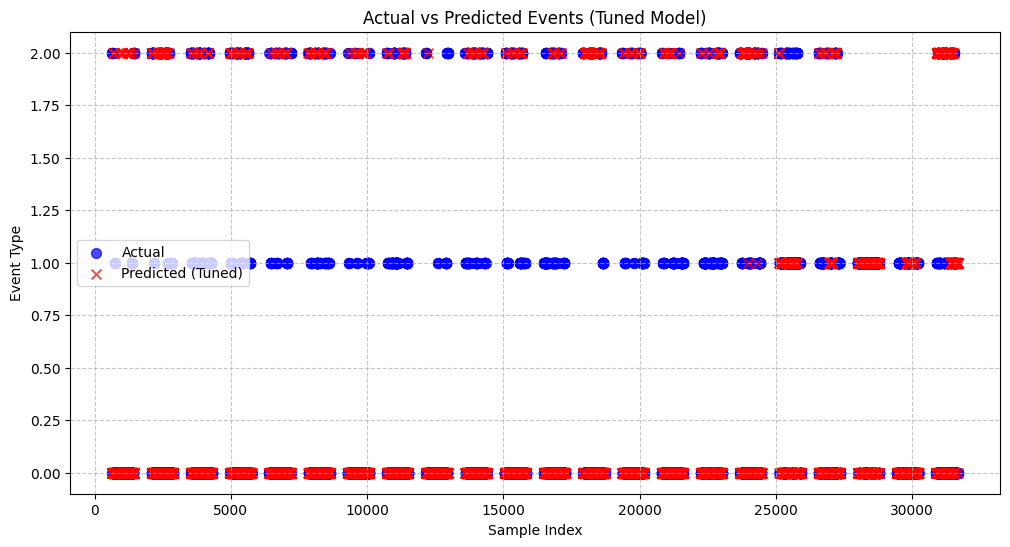

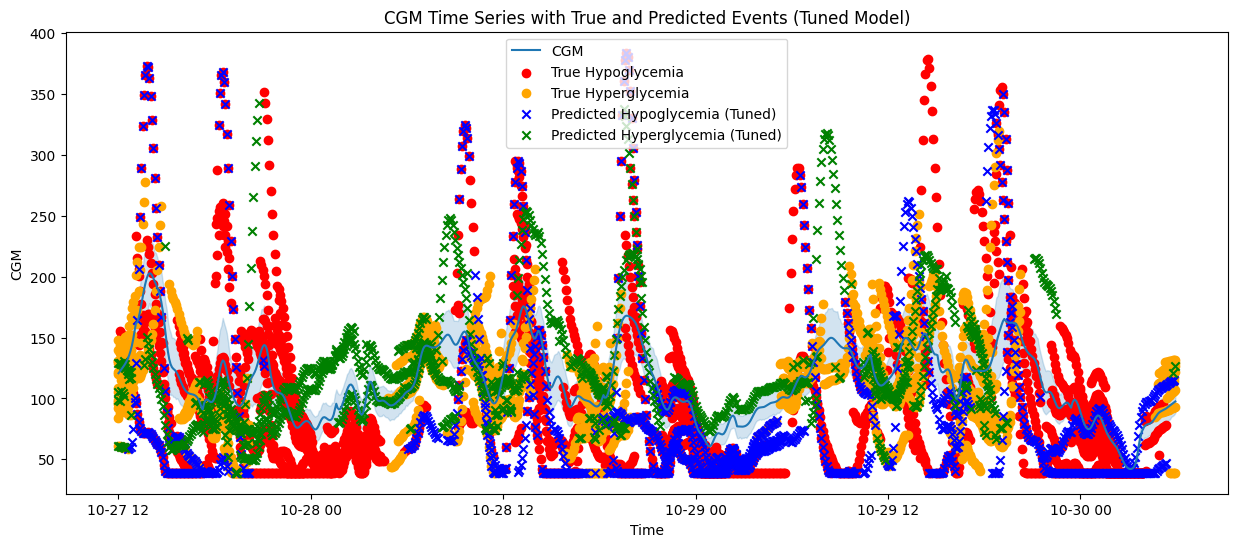

In [ ]:
# Assuming you have already defined cm_tuned, y_pred_tuned, and other necessary variables

# Plot the confusion matrix for the tuned model using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot actual vs predicted events for the tuned model with different markers and colors
plt.figure(figsize=(12, 6))
plt.scatter(test_df.index, test_df[target].values, label='Actual', color='blue', marker='o', alpha=0.7, s=50)
plt.scatter(test_df.index, y_pred_tuned, label='Predicted (Tuned)', color='red', marker='x', alpha=0.7, s=50)
plt.title('Actual vs Predicted Events (Tuned Model)')
plt.xlabel('Sample Index')
plt.ylabel('Event Type')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plotting the time series with true events and predictions
plt.figure(figsize=(15, 6))

# Plot CGM values
sns.lineplot(x='Time', y='CGM', data=test_df, label='CGM')

# Highlight true events
true_hypo = test_df[test_df['target'] == 1]
true_hyper = test_df[test_df['target'] == 2]
plt.scatter(true_hypo['Time'], true_hypo['CGM'], color='red', marker='o', label='True Hypoglycemia')
plt.scatter(true_hyper['Time'], true_hyper['CGM'], color='orange', marker='o', label='True Hyperglycemia')

# Highlight predicted events from the tuned model
predicted_hypo_tuned = test_df[y_pred_tuned == 1]
predicted_hyper_tuned = test_df[y_pred_tuned == 2]
plt.scatter(predicted_hypo_tuned['Time'], predicted_hypo_tuned['CGM'], color='blue', marker='x', label='Predicted Hypoglycemia (Tuned)')
plt.scatter(predicted_hyper_tuned['Time'], predicted_hyper_tuned['CGM'], color='green', marker='x', label='Predicted Hyperglycemia (Tuned)')

plt.title('CGM Time Series with True and Predicted Events (Tuned Model)')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.legend()
plt.show()


#  To check the performance of the pipeline without using future values of CHO and insulin

C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\1210689540.py:42: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  split_time = pd.to_datetime('27/10/2023 12:00')
C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\1210689540.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target].fillna(most_frequent_class, inplace=True)
C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\1210689540.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target].fillna(most_frequent_class, inplace=Tr

Classification Report (Without Future Values):
              precision    recall  f1-score   support

           0       0.72      0.81      0.76     12266
           1       0.51      0.17      0.26      3240
           2       0.18      0.24      0.20      1918

    accuracy                           0.63     17424
   macro avg       0.47      0.41      0.41     17424
weighted avg       0.62      0.63      0.61     17424

Confusion Matrix (Without Future Values):
[[9928  499 1839]
 [2418  565  257]
 [1425   36  457]]


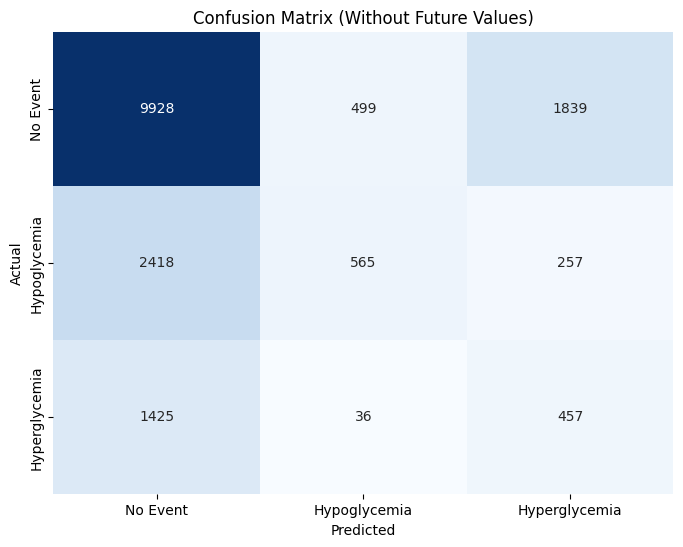

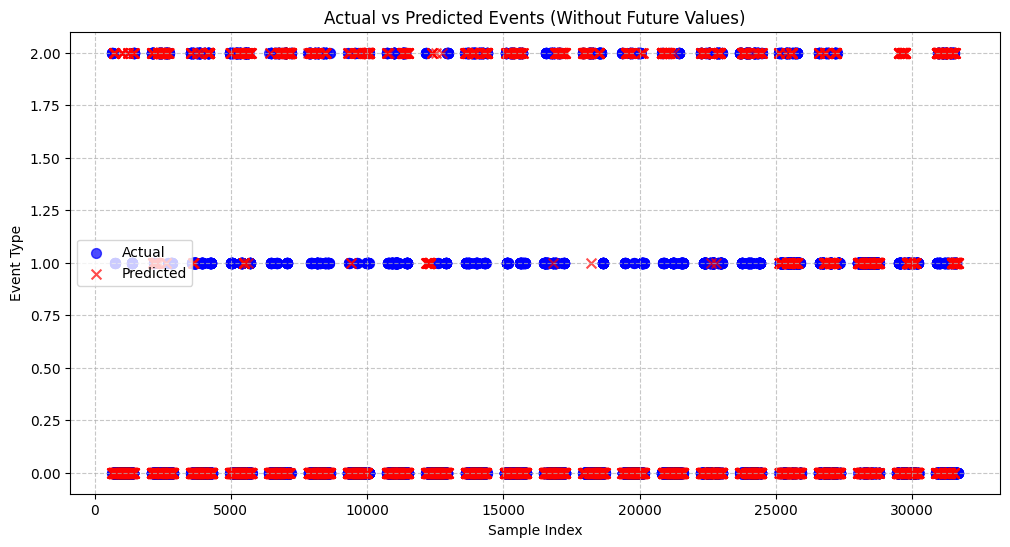

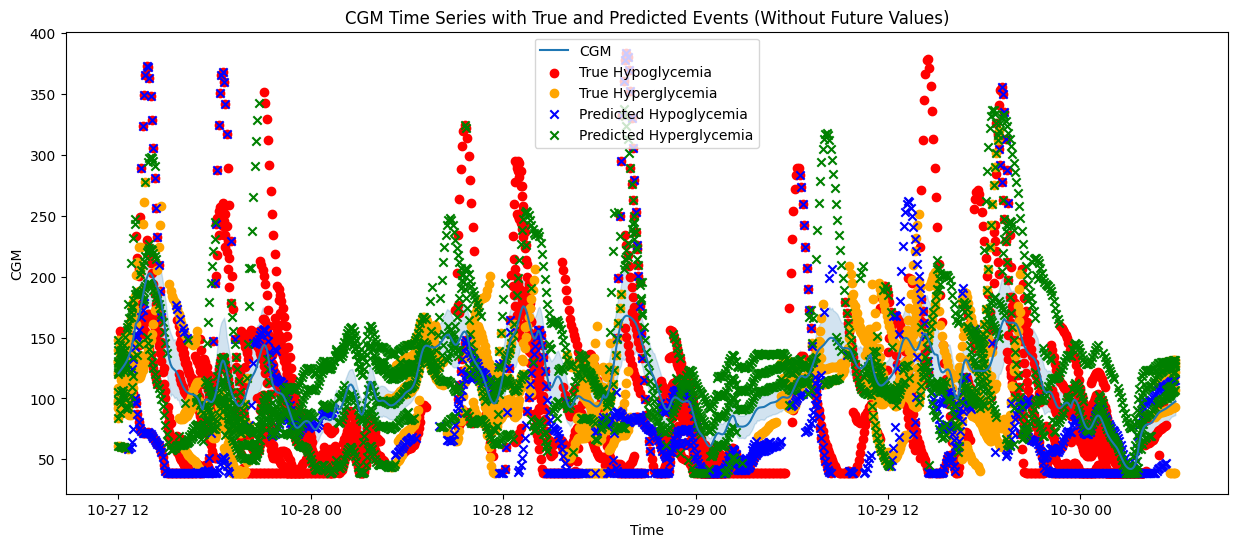

In [ ]:
# Select features and target variable
features = ['CGM_avg_24hrs', 'CHO_avg_24hrs', 'insulin_avg_24hrs']
target = 'target'

# Impute missing values in the target variable with the most frequent class
most_frequent_class = train_df[target].mode()[0]
train_df[target].fillna(most_frequent_class, inplace=True)
test_df[target].fillna(most_frequent_class, inplace=True)

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(train_df[features])
X_test_imputed = imputer.transform(test_df[features])

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_imputed, train_df[target])

# Predict on the test set
y_pred = rf_classifier.predict(X_test_imputed)

# Print classification report
print("Classification Report (Without Future Values):")
print(classification_report(test_df[target], y_pred))

# Calculate confusion matrix
cm = confusion_matrix(test_df[target], y_pred)
print("Confusion Matrix (Without Future Values):")
print(cm)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix (Without Future Values)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot actual vs predicted events with different markers and colors
plt.figure(figsize=(12, 6))
plt.scatter(test_df.index, test_df[target].values, label='Actual', color='blue', marker='o', alpha=0.7, s=50)
plt.scatter(test_df.index, y_pred, label='Predicted', color='red', marker='x', alpha=0.7, s=50)
plt.title('Actual vs Predicted Events (Without Future Values)')
plt.xlabel('Sample Index')
plt.ylabel('Event Type')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Assuming 'Time' is the time column in your dataframe
time_column = 'Time'

# Plotting the time series with true events and predictions
plt.figure(figsize=(15, 6))

# Plot CGM values
sns.lineplot(x=time_column, y='CGM', data=test_df, label='CGM')

# Highlight true events
true_hypo = test_df[test_df['target'] == 1]
true_hyper = test_df[test_df['target'] == 2]
plt.scatter(true_hypo[time_column], true_hypo['CGM'], color='red', marker='o', label='True Hypoglycemia')
plt.scatter(true_hyper[time_column], true_hyper['CGM'], color='orange', marker='o', label='True Hyperglycemia')

# Highlight predicted events
predicted_hypo = test_df[y_pred == 1]
predicted_hyper = test_df[y_pred == 2]
plt.scatter(predicted_hypo[time_column], predicted_hypo['CGM'], color='blue', marker='x', label='Predicted Hypoglycemia')
plt.scatter(predicted_hyper[time_column], predicted_hyper['CGM'], color='green', marker='x', label='Predicted Hyperglycemia')

plt.title('CGM Time Series with True and Predicted Events (Without Future Values)')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.legend()
plt.show()



# Hyperparameter Tuining

C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\3055906413.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[target].fillna(most_frequent_class, inplace=True)
C:\Users\shaur\AppData\Local\Temp\ipykernel_12136\3055906413.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[target].fillna(most_frequent_class, inplace=True)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.72      0.90      0.80     12266
           1       0.59      0.16      0.25      3240
           2       0.20      0.12      0.15      1918

    accuracy                           0.68     17424
   macro avg       0.50      0.39      0.40     17424
weighted avg       0.64      0.68      0.63     17424

Confusion Matrix (Tuned Model):
[[11051   338   877]
 [ 2651   504    85]
 [ 1663    18   237]]


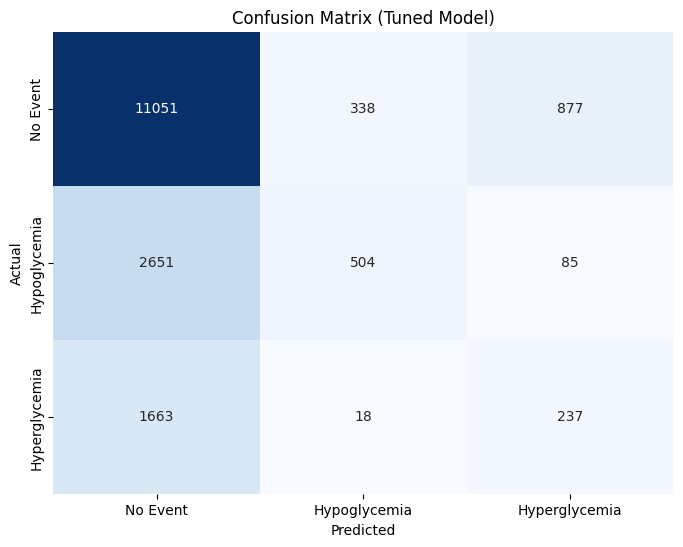

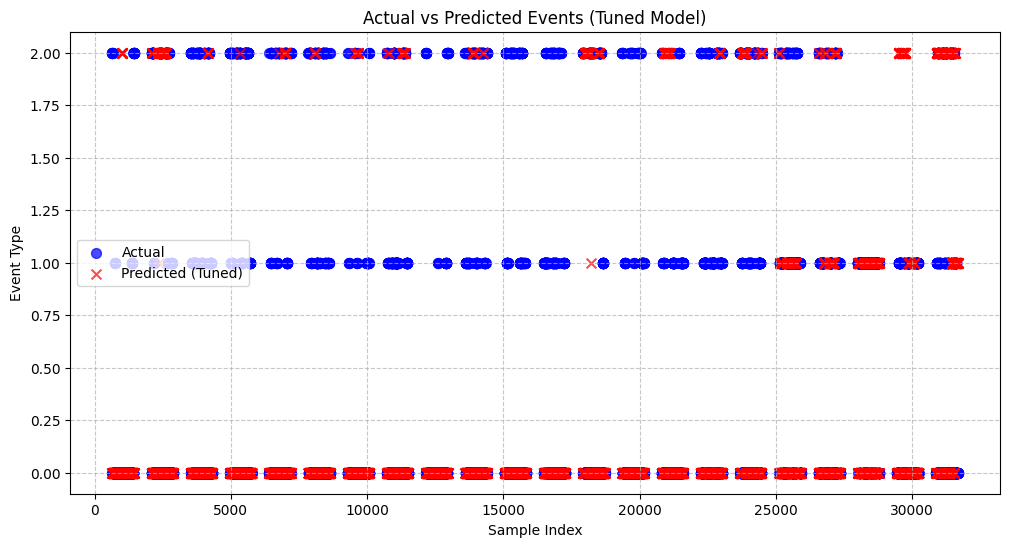

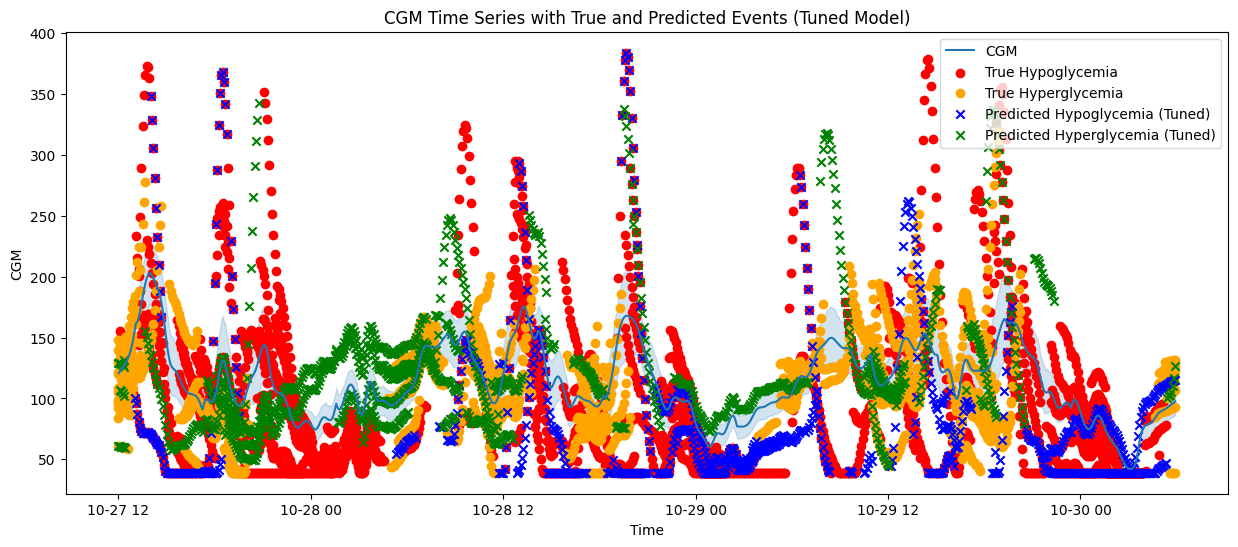

In [ ]:
# Select features and target variable
features = ['CGM_avg_24hrs', 'CHO_avg_24hrs', 'insulin_avg_24hrs']
target = 'target'

# Impute missing values in the target variable with the most frequent class
most_frequent_class = train_df[target].mode()[0]
train_df[target].fillna(most_frequent_class, inplace=True)
test_df[target].fillna(most_frequent_class, inplace=True)

# Impute missing values in features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(train_df[features])
X_test_imputed = imputer.transform(test_df[features])

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for tuning
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the model with grid search for tuning
grid_search.fit(X_train_imputed, train_df[target])

# Get the best parameters from grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to initialize the tuned Random Forest Classifier
rf_classifier_tuned = RandomForestClassifier(random_state=42, **best_params)

# Train the tuned model
rf_classifier_tuned.fit(X_train_imputed, train_df[target])

# Predict on the test set with the tuned model
y_pred_tuned = rf_classifier_tuned.predict(X_test_imputed)

# Print classification report for the tuned model
print("Classification Report (Tuned Model):")
print(classification_report(test_df[target], y_pred_tuned))

# Calculate confusion matrix for the tuned model
cm_tuned = confusion_matrix(test_df[target], y_pred_tuned)
print("Confusion Matrix (Tuned Model):")
print(cm_tuned)

# Plot the confusion matrix for the tuned model using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot actual vs predicted events for the tuned model with different markers and colors
plt.figure(figsize=(12, 6))
plt.scatter(test_df.index, test_df[target].values, label='Actual', color='blue', marker='o', alpha=0.7, s=50)
plt.scatter(test_df.index, y_pred_tuned, label='Predicted (Tuned)', color='red', marker='x', alpha=0.7, s=50)
plt.title('Actual vs Predicted Events (Tuned Model)')
plt.xlabel('Sample Index')
plt.ylabel('Event Type')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Assuming 'Time' is the time column in your dataframe
time_column = 'Time'

# Plotting the time series with true events and predictions for the tuned model
plt.figure(figsize=(15, 6))

# Plot CGM values
sns.lineplot(x=time_column, y='CGM', data=test_df, label='CGM')

# Highlight true events
true_hypo = test_df[test_df['target'] == 1]
true_hyper = test_df[test_df['target'] == 2]
plt.scatter(true_hypo[time_column], true_hypo['CGM'], color='red', marker='o', label='True Hypoglycemia')
plt.scatter(true_hyper[time_column], true_hyper['CGM'], color='orange', marker='o', label='True Hyperglycemia')

# Highlight predicted events for the tuned model
predicted_hypo_tuned = test_df[y_pred_tuned == 1]
predicted_hyper_tuned = test_df[y_pred_tuned == 2]
plt.scatter(predicted_hypo_tuned[time_column], predicted_hypo_tuned['CGM'], color='blue', marker='x', label='Predicted Hypoglycemia (Tuned)')
plt.scatter(predicted_hyper_tuned[time_column], predicted_hyper_tuned['CGM'], color='green', marker='x', label='Predicted Hyperglycemia (Tuned)')

plt.title('CGM Time Series with True and Predicted Events (Tuned Model)')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.legend()
plt.show()


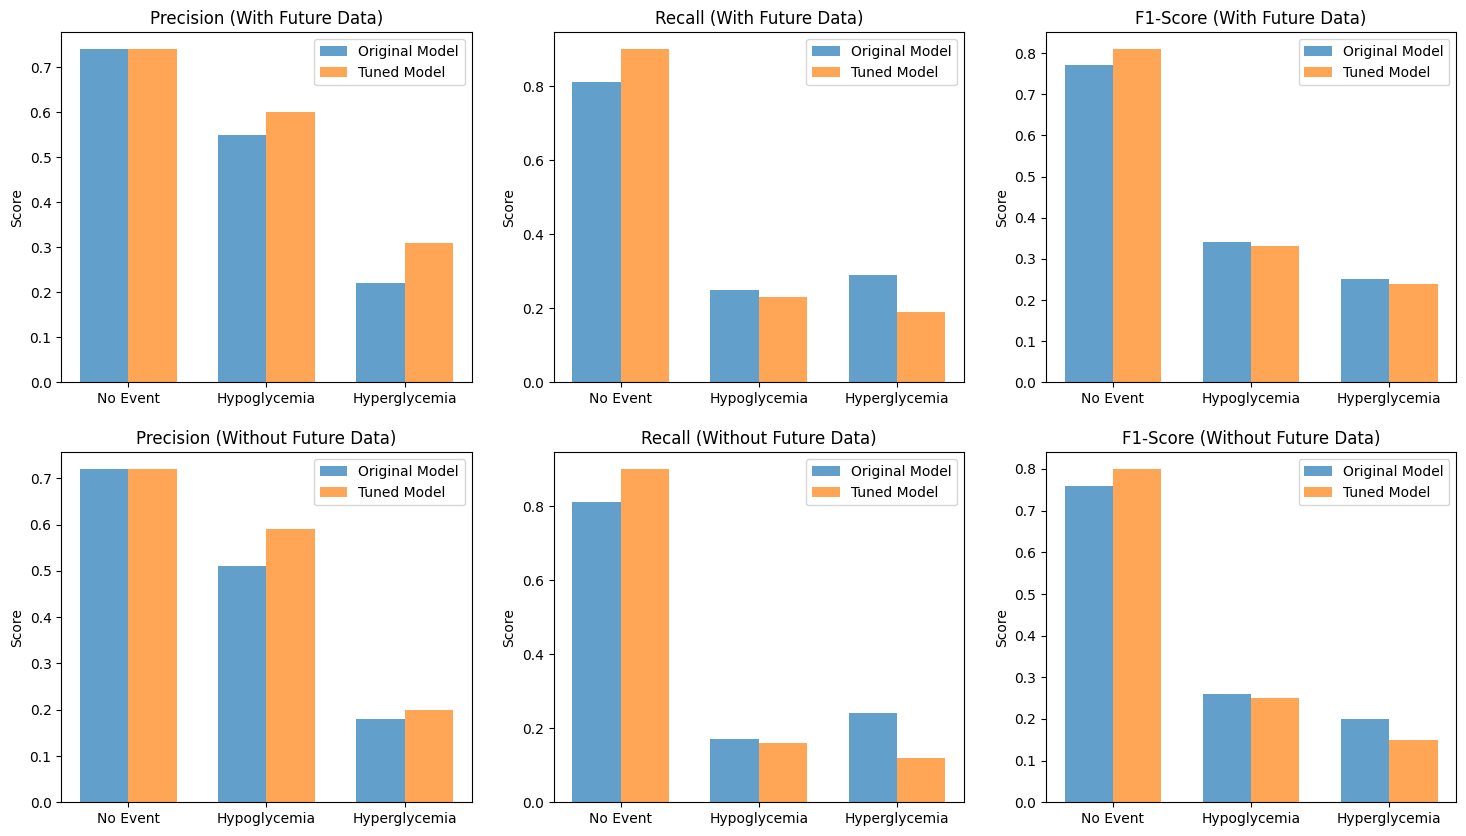

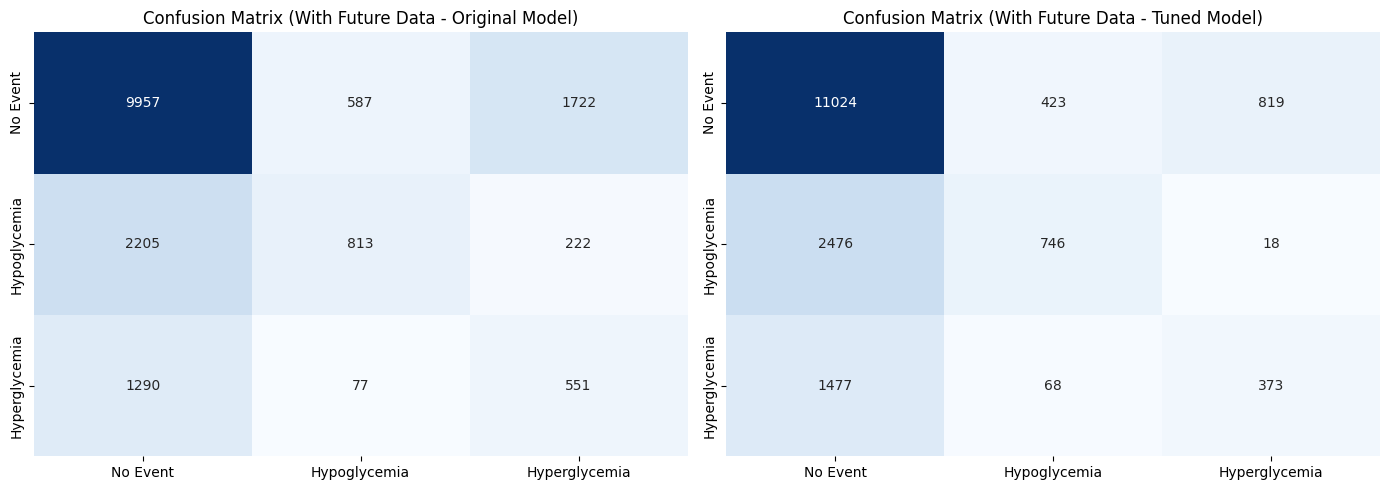

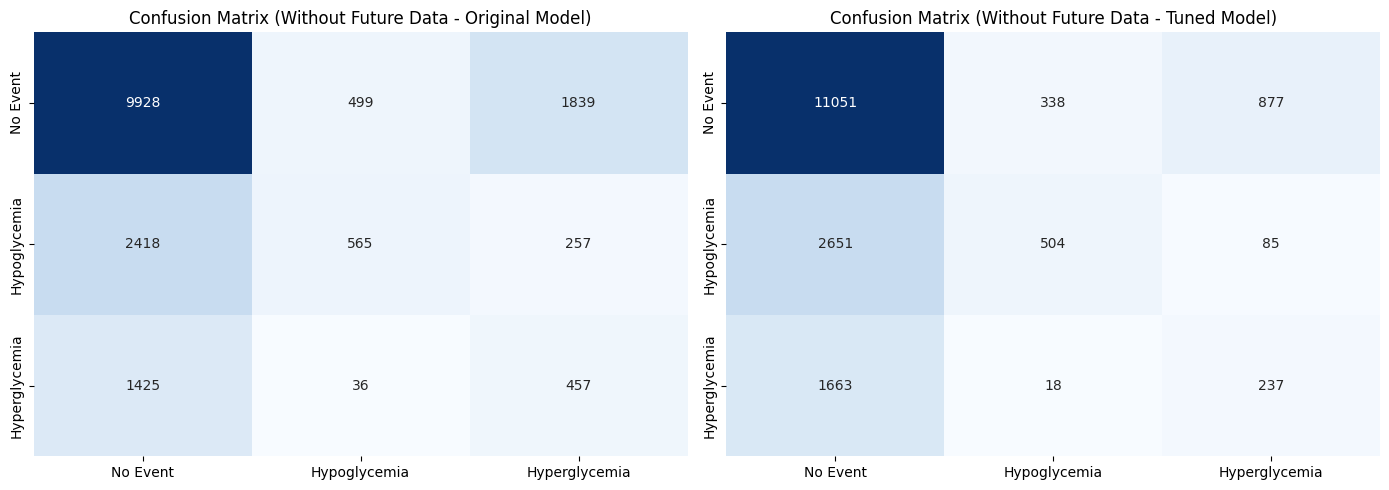

In [ ]:
import numpy as np

# Results for with future data
precision_with = [0.74, 0.55, 0.22]
recall_with = [0.81, 0.25, 0.29]
f1_score_with = [0.77, 0.34, 0.25]

precision_tuned_with = [0.74, 0.60, 0.31]
recall_tuned_with = [0.90, 0.23, 0.19]
f1_score_tuned_with = [0.81, 0.33, 0.24]

# Results for without future data
precision_without = [0.72, 0.51, 0.18]
recall_without = [0.81, 0.17, 0.24]
f1_score_without = [0.76, 0.26, 0.20]

precision_tuned_without = [0.72, 0.59, 0.20]
recall_tuned_without = [0.90, 0.16, 0.12]
f1_score_tuned_without = [0.80, 0.25, 0.15]

# Bar plot for precision, recall, and f1-score
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

labels = ['No Event', 'Hypoglycemia', 'Hyperglycemia']

def plot_metric(ax, metric, metric_tuned, title):
    x = np.arange(len(labels))
    width = 0.35

    ax.bar(x - width/2, metric, width, label='Original Model', alpha=0.7)
    ax.bar(x + width/2, metric_tuned, width, label='Tuned Model', alpha=0.7)

    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

plot_metric(axes[0, 0], precision_with, precision_tuned_with, 'Precision (With Future Data)')
plot_metric(axes[0, 1], recall_with, recall_tuned_with, 'Recall (With Future Data)')
plot_metric(axes[0, 2], f1_score_with, f1_score_tuned_with, 'F1-Score (With Future Data)')

plot_metric(axes[1, 0], precision_without, precision_tuned_without, 'Precision (Without Future Data)')
plot_metric(axes[1, 1], recall_without, recall_tuned_without, 'Recall (Without Future Data)')
plot_metric(axes[1, 2], f1_score_without, f1_score_tuned_without, 'F1-Score (Without Future Data)')

# Confusion matrix for with future data
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap([[9957, 587, 1722],
             [2205, 813, 222],
             [1290, 77, 551]],
            annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix (With Future Data - Original Model)')

plt.subplot(1, 2, 2)
sns.heatmap([[11024, 423, 819],
             [2476, 746, 18],
             [1477, 68, 373]],
            annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix (With Future Data - Tuned Model)')

plt.tight_layout()
plt.show()

# Confusion matrix for without future data
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap([[9928, 499, 1839],
             [2418, 565, 257],
             [1425, 36, 457]],
            annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix (Without Future Data - Original Model)')

plt.subplot(1, 2, 2)
sns.heatmap([[11051, 338, 877],
             [2651, 504, 85],
             [1663, 18, 237]],
            annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'],
            yticklabels=['No Event', 'Hypoglycemia', 'Hyperglycemia'])
plt.title('Confusion Matrix (Without Future Data - Tuned Model)')

plt.tight_layout()
plt.show()


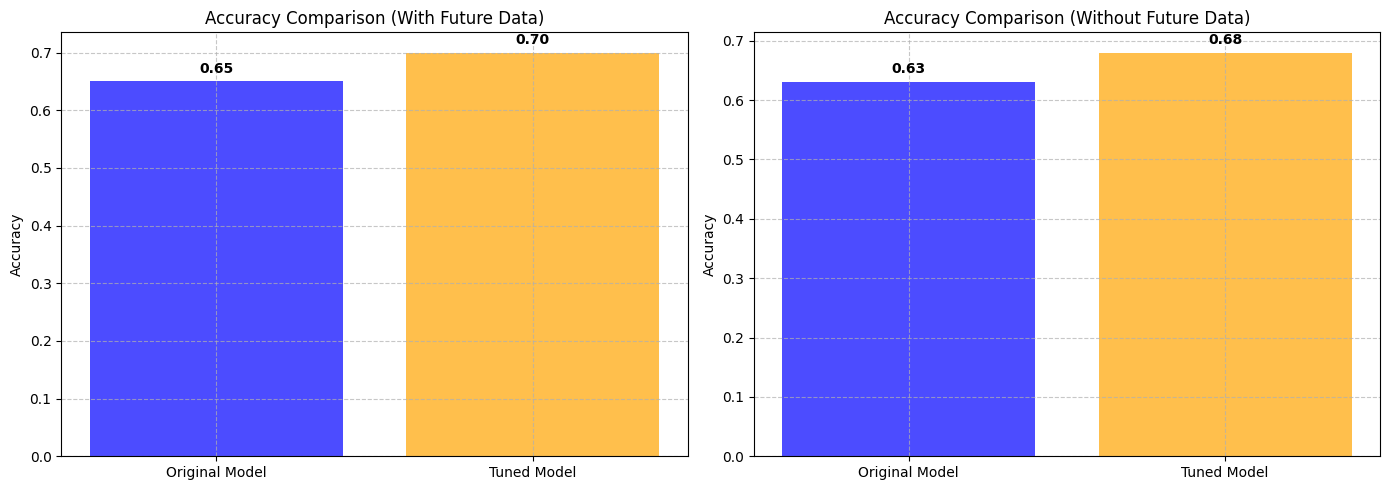

In [ ]:
# Results for with future data
accuracy_with = 0.65
accuracy_tuned_with = 0.70

# Results for without future data
accuracy_without = 0.63
accuracy_tuned_without = 0.68

# Bar plot for accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Results for with future data
labels_acc_with = ['Original Model', 'Tuned Model']
accuracy_values_with = [accuracy_with, accuracy_tuned_with]

# Results for without future data
labels_acc_without = ['Original Model', 'Tuned Model']
accuracy_values_without = [accuracy_without, accuracy_tuned_without]

def plot_accuracy(ax, labels, values, title):
    ax.bar(labels, values, color=['blue', 'orange'], alpha=0.7)
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add text labels with accuracy values
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot for with future data
plot_accuracy(axes[0], labels_acc_with, accuracy_values_with, 'Accuracy Comparison (With Future Data)')

# Plot for without future data
plot_accuracy(axes[1], labels_acc_without, accuracy_values_without, 'Accuracy Comparison (Without Future Data)')

plt.tight_layout()
plt.show()
